In [1]:
!export PYTHONHASHSEED=0

In [2]:
import sys
sys.path.append('../src')
import numpy as np
import cloudpickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import (r2_score, average_precision_score)

from itertools import product
%matplotlib inline
from matrix_completion import MCScaler, PMF, PMF_b
from cv import get_eval_pair_list
from utils import sparsity, evaluate_model
from i_o import setup_logging
setup_logging()

from cv import get_mask
np.random.seed(26849)

In [3]:
def load_data(name):
    data_fp = {
    'collins': '../data/gi/output/collins_et_al/collins_et_al-dels_only.cpkl',
        
    'costanzo': '../data/gi/output/symmetrized/costanzo_et_al_2010-GI_score.cpkl',
    'dcell_data' : '../data/gi/output/symmetrized/dcell_data-GI_score.cpkl',
    'dcell_data_pvals' : '../data/gi/output/symmetrized/dcell_data-p_vals.cpkl'
    }
    with open (data_fp[name], 'rb') as f:
        return cloudpickle.load(f)


In [4]:
from sklearn.model_selection import KFold
def gi_k_fold_cv(gi_data, n_splits=4):
    '''
    Returns Train_X, Test_X, eval_mask
    
    eval_mask is mask of unique pairs for evaluation
    '''
    
    rows = gi_data['rows']
    cols = gi_data['cols']
    values = gi_data['values']
    col_g2i = dict((n, i) for i, n in enumerate(cols))
    row_g2i = dict((n, i) for i, n in enumerate(rows))
    
    rowset = set(rows)
    colset = set(cols)
    
    pairs = product(rows, cols)
    pairs =  set(frozenset((a,b)) for a,b in pairs if a != b)
    pairs = np.asarray([tuple(p) for p in pairs])
    
    kf = KFold(n_splits=n_splits, random_state=None, shuffle=False)
    
    fold_masks = []
    
    n_pairs = 0
    for train_index, test_index in kf.split(pairs):
        train_pairs, test_pairs = pairs[train_index], pairs[test_index]
        
        test_mask = get_mask(test_pairs, values.shape, row_g2i, col_g2i)

        value_mask = ~np.isnan(values)
        test_mask =  np.logical_and(value_mask,  test_mask)
        train_mask = np.logical_and(value_mask, ~test_mask)

        train_X = np.where(train_mask, values, np.nan)
        test_X = np.where(test_mask, values, np.nan)

        # Get mask for evaluation time... (this mask only has one gi score per pair)
        eval_pairs1, eval_pairs2 = get_eval_pair_list(test_pairs, row_g2i, col_g2i, gi_data)
        assert(np.all(~np.isnan(test_X[test_mask])))

        assert(np.all(~np.isnan(test_X[eval_pairs1[0], eval_pairs1[1]])))
        assert(np.all(~np.isnan(test_X[eval_pairs2[0], eval_pairs2[1]])))
        assert(len(eval_pairs1[0]) == len(eval_pairs2[0]))
        
        n_pairs += len(eval_pairs1[0])
        
        fold_masks.append((train_X, test_X, (eval_pairs1, eval_pairs2)))
    
    # check that the nand of all the eval masks is true
    
    print('# pairs with scores', n_pairs)
    return fold_masks

_ = gi_k_fold_cv(load_data('collins'), n_splits=4)

# pairs with scores 150636


In [5]:
_ = gi_k_fold_cv(load_data('costanzo'), n_splits=2)

# pairs with scores 3982982


In [6]:
dcell_data = load_data('dcell_data')
dcell_pvals_data = load_data('dcell_data_pvals')
dcell_pvals = dcell_pvals_data['values']
pvals_filled = np.where(np.isnan(dcell_pvals), 1000, dcell_pvals)
pvals_mask = pvals_filled < 0.05

In [7]:
folds = gi_k_fold_cv(dcell_data, n_splits=4)

# pairs with scores 3331165


In [8]:
print('dcell_data shape:', dcell_data['values'].shape)
print('dcell_data total genes:', len(set(dcell_data['rows']) | set(dcell_data['cols'])))
print('3586 genes matches number reported in Yu et al. (Cell Systems, 2016) supplement')

dcell_data shape: (1367, 3351)
dcell_data total genes: 3586
3586 genes matches number reported in Yu et al. (Cell Systems, 2016) supplement


In [9]:
all_imputed = []
all_sig_imputed = []
all_sig_true = []
all_true = []

for train_X, test_X, eval_pairs in folds:
    scaler = MCScaler('std')
    train_X = scaler.fit_transform(train_X)
    pairlist0, pairlist1 = eval_pairs
    
    print('# pairs in test for this fold', len(pairlist0[0]))
    pmf_b = PMF_b(rank=170, max_iter=79, lambda_f=36.9, lr=0.273, lambda_b=0.23, report_every=10, use_sigmoid=False)
    pmf_b.fit(train_X)
    
    imputed = pmf_b.X_fitted
    imputed = scaler.inverse_transform(imputed)
    
    
    preds = (imputed[pairlist0[0], pairlist0[1]] + imputed[pairlist1[0], pairlist1[1]]) / 2
    true = test_X[pairlist0[0], pairlist0[1]]
    _true = test_X[pairlist1[0], pairlist1[1]]
    assert(np.allclose(true, _true))
    
    pvals = dcell_pvals[pairlist0[0], pairlist0[1]]
    
    sig_preds = preds[pvals < 0.05] 
    sig_trues = true[pvals < 0.05]
    
    sig_results = evaluate_model(sig_trues, sig_preds)
    all_results = evaluate_model(true, preds)
    print('* results on sig pairs')
    print(sig_results)
    print('* results on all pairs')
    print(all_results)
    
    all_imputed = np.concatenate((all_imputed, preds))
    all_true = np.concatenate((all_true, true))

    all_sig_imputed = np.concatenate((all_sig_imputed, sig_preds))
    all_sig_true = np.concatenate((all_sig_true, sig_trues))

    

# pairs in test for this fold 832888
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
2020-05-02 14:41:08,354 WARNING   : From /fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/xsmf-gpu_/lib/python3.6/site-packages/tensorflow_core/python/ops/array_ops.py:1475: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
2020-05-02 14:41:10,222 WARNING   : From ../src/matrix_completion.py:866: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.

2020-05-02 14:41:10,225 WARNING   : From ../src/matrix_completion.py:648: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead

2020-05-02 14:42:11,605 INFO      : 	iter=   20 | Training   | Cost=1164899.8012
2020-05-02 14:42:11,606 INFO      : 	iter=   20 | Training   | R2=  0.4379
2020-05-02 14:42:11,913 INFO      : 	iter=   30 | Training   | Cost=1092287.7963
2020-05-02 14:42:11,914 INFO      : 	iter=   30 | Training   | R2=  0.4961
2020-05-02 14:42:12,222 INFO      : 	iter=   40 | Training   | Cost=1065798.6633
2020-05-02 14:42:12,223 INFO      : 	iter=   40 | Training   | R2=  0.5142
2020-05-02 14:42:12,531 INFO      : 	iter=   50 | Training   | Cost=1055852.7335
2020-05-02 14:42:12,532 INFO      : 	iter=   50 | Training   | R2=  0.5213
2020-05-02 14:42:12,840 INFO      : 	iter=   60 | Training   | Cost=1052146.4796
2020-05-02 14:42:12,840 INFO      : 	iter=   60 | Training   | R2=  0.5236
2020-05-02 14:42:13,148 INFO      : 	iter=   70 | Training   | Cost=1050767.6959
2020-05-02 14:42:13,149 INFO      : 	iter=   70 | Training   | R2=  0.5246
2020-05-02 14:42:13,395 INFO      : 	stopping due to max-iterati

In [10]:
print('Total pairs imputed:', len(all_true))
print('Total significant pairs imputed', len(all_sig_true))

Total pairs imputed: 3331165
Total significant pairs imputed 450187


In [11]:
print('Results on all pairs')
evaluate_model(all_true, all_imputed)

Results on all pairs


{'pearsonr_score': 0.4324488142687669,
 'pearsonr_pval': 0.0,
 'r2': 0.18592335257978443,
 'mse': 0.0014122521812389268,
 'nrmse': 0.9022619616387557}

In [12]:
print('Results on significant pairs')
evaluate_model(all_sig_true, all_sig_imputed)

Results on significant pairs


{'pearsonr_score': 0.6022751862939881,
 'pearsonr_pval': 0.0,
 'r2': 0.27031009511151516,
 'mse': 0.005466996663907941,
 'nrmse': 0.8542188858181987}

In [13]:
aupr = average_precision_score(all_true < -0.08, -all_imputed)
print("AUPR for all pairs:", aupr)

AUPR for all pairs: 0.26553249424300146


In [14]:
aupr = average_precision_score(all_sig_true < -0.08, -all_sig_imputed)
print("AUPR for significant pairs:", aupr)

AUPR for significant pairs: 0.5671242967212318


# Compare to DCell and Ontotype

In [15]:
import pandas as pd
dcell_onto_preds_fp = '../data/gi/output/dcell_and_ontotype/dcell-onto-data.tsv'
dcell_onto_preds_df = pd.read_csv(dcell_onto_preds_fp, sep='\t')

from scipy.stats import pearsonr
def report_GO_methods(df, key):
    print('On all GI scores')
    print('R2:', r2_score(df['true'], df[key]))
    print('pearsonr:', pearsonr(df['true'], df[key]))
    print('AUPR:', average_precision_score(df['true'] < -0.08, -1 * df[key]))
    print()
    print('On significant GI scores')
    sig_df = df[df['p'] < 0.05]
    print('R2:', r2_score(sig_df['true'], sig_df[key]))
    print('pearsonr:', pearsonr(sig_df['true'], sig_df[key]))
    print('AUPR:', average_precision_score(sig_df['true'] < -0.08, -1 * sig_df[key]))

In [16]:
report_GO_methods(dcell_onto_preds_df, 'onto_pred')

On all GI scores
R2: -0.023464707210215874
pearsonr: (0.19128345723244247, 0.0)
AUPR: 0.10352683954894583

On significant GI scores
R2: 0.11179723633797911
pearsonr: (0.34525233666602606, 0.0)
AUPR: 0.34344264215324194


In [17]:
report_GO_methods(dcell_onto_preds_df, 'dcell_pred')

On all GI scores
R2: -0.01659717848219433
pearsonr: (0.35853263308346905, 0.0)
AUPR: 0.2028207697181206

On significant GI scores
R2: 0.26467359783017963
pearsonr: (0.5144643842331992, 0.0)
AUPR: 0.4800702618571785


## Results tables

### All pairs

| Alg      | R2  | Corr. | AUPR |
| -        | -   |-      | -    |
| MF-b     |0.187|0.433  |0.267 |
| DCell    | < 0 |0.359  |0.203 |
| Ontotype | < 0 |0.191  |0.104 |

### Significant Pairs

| Alg      | R2  | Corr. | AUPR |
| -        | -   |-      | -    |
| MF-b     |0.271|0.604  |0.570 |
| DCell    |0.265|0.514  |0.480 |
| Ontotype |0.112|0.345  |0.343 |



## Visualizing imputed scores - PR curves

Text(0, 0.5, 'Precision')

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/xsmf-gpu_/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


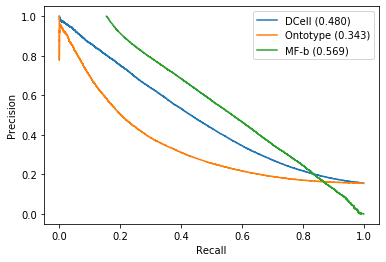

In [18]:
from sklearn.metrics import precision_recall_curve
sig_df =  dcell_onto_preds_df[dcell_onto_preds_df['p'] < 0.05]
dcell_p, dcell_r, _ = precision_recall_curve(sig_df['true'] < -0.08, -1 * sig_df['dcell_pred'])
onto_p, onto_r, _ = precision_recall_curve(sig_df['true'] < -0.08, -1 * sig_df['onto_pred'])
mf_p, mf_r, _ = precision_recall_curve(all_sig_true < -0.08, -all_sig_imputed)

plt.plot(dcell_r, dcell_p, label='DCell (0.480)')
plt.plot(onto_r, onto_p, label='Ontotype (0.343)')

plt.plot(mf_p, mf_r, label='MF-b (0.569)')

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

Text(0, 0.5, 'Precision')

/fs/cbcb-lab/mdml/users/jason/bin/miniconda3/envs/xsmf-gpu_/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


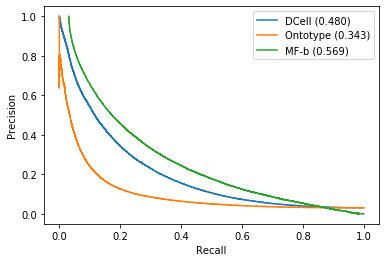

In [19]:
dcell_p, dcell_r, _ = precision_recall_curve(dcell_onto_preds_df['true'] < -0.08, -1 * dcell_onto_preds_df['dcell_pred'])
onto_p, onto_r, _ = precision_recall_curve(dcell_onto_preds_df['true'] < -0.08, -1 * dcell_onto_preds_df['onto_pred'])
mf_p, mf_r, _ = precision_recall_curve(all_true < -0.08, -all_imputed)

plt.plot(dcell_r, dcell_p, label='DCell (0.480)')
plt.plot(onto_r, onto_p, label='Ontotype (0.343)')

plt.plot(mf_p, mf_r, label='MF-b (0.569)')

plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')

In [20]:
len(all_sig_imputed)
len(sig_df['true'])

450187

## Visualizing imputed scores - imputed vs true values

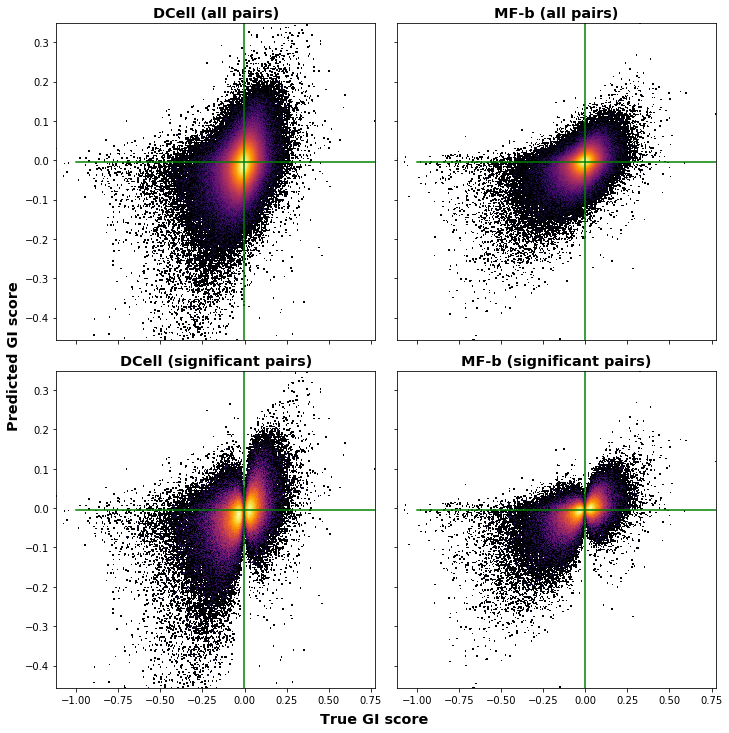

In [22]:
import matplotlib.colors as mcolors

dcell_true, dcell_preds = dcell_onto_preds_df['true'], dcell_onto_preds_df['dcell_pred']
true_mean = dcell_true.mean()

fig, axs = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

#fig.suptitle('DCell vs. MF-b - True vs. Predicted', weight='bold')
axs[0, 0].hist2d(dcell_onto_preds_df['true'], dcell_onto_preds_df['dcell_pred'], 
                 bins=600, norm=mcolors.LogNorm(), cmap='inferno')
axs[0, 0].plot([-1, 1], [true_mean, true_mean], c='g')
axs[0, 0].plot([true_mean, true_mean], [-1, 1], c='g')
axs[0,0].set_title('DCell (all pairs)', weight='bold', size='x-large')

axs[0, 1].hist2d(all_true, all_imputed, 
                 bins=600, norm=mcolors.LogNorm(), cmap='inferno')
axs[0, 1].plot([-1, 1], [true_mean, true_mean], c='g')
axs[0, 1].plot([true_mean, true_mean], [-1, 1], c='g')
axs[0, 1].set_title('MF-b (all pairs)', weight='bold', size='x-large')

axs[1, 0].hist2d(sig_df['true'], sig_df['dcell_pred'], 
                 bins=600, norm=mcolors.LogNorm(), cmap='inferno')
axs[1, 0].plot([-1, 1], [true_mean, true_mean], c='g')
axs[1, 0].plot([true_mean, true_mean], [-1, 1], c='g')
axs[1, 0].set_title('DCell (significant pairs)', weight='bold', size='x-large')

axs[1, 1].hist2d(all_sig_true, 
                  all_sig_imputed, 
                  bins=600, norm=mcolors.LogNorm(), cmap='inferno')
axs[1, 1].plot([-1, 1], [true_mean, true_mean], c='g')
axs[1, 1].plot([true_mean, true_mean], [-1, 1], c='g')
axs[1,1].set_title('MF-b (significant pairs)', weight='bold', size='x-large')

fig.text(0.5, -0.01, 'True GI score', ha='center', weight='bold', size='x-large')
fig.text(-0.01, 0.5, 'Predicted GI score', va='center', rotation='vertical', weight='bold', size='x-large')
fig.tight_layout()

print()

In [38]:
def pred_rates(true, pred):
    true_pos = np.sum(np.logical_and(true, pred)) 
    false_pos = np.sum(np.logical_and(~true, pred)) 
    true_neg = np.sum(np.logical_and(~true, ~pred)) 
    false_neg = np.sum(np.logical_and(true, ~pred)) 
    
    tpr = true_pos / np.sum(true)
    fpr = false_pos / np.sum(~true)
    tnr = true_neg / np.sum(~true)
    fnr = false_neg / np.sum(~true)
    
    prec = true_pos / (true_pos + false_pos)
    
    print('TPR:', tpr)
    print('FPR:', fpr)
    print('TNR:', tnr)
    print('FNR:', fnr)
    
    print('Precision:', prec)

In [39]:
pred_rates(all_true < -0.08, all_imputed < -0.08)

TPR: 0.08123055651572762
FPR: 0.001047406939597777
TNR: 0.9989525930604022
FNR: 0.02965215243675506
Precision: 0.714527027027027


In [40]:
pred_rates(dcell_true < -0.08, dcell_preds < -0.08)

TPR: 0.18651342320543843
FPR: 0.010443390908693695
TNR: 0.9895566090913063
FNR: 0.026254277557261087
Precision: 0.3656401761849189
